In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from qcl.testing.OneDimDataset import prepare_dataset,eval

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

from qcl.regressors.StandardQCLRegressor import StandardQCLRegressor
from qcl.gates.CNOTRotationGates import CNOTRotationGates
from qcl.Encoders.XYEncoder import XYEncoder
from qcl.Encoders.prerocess import *
from qcl.gates.Observable import ZObservable
#from qcl.testing.DNNModel import DNNModel

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF


/home/s13/u13001/.conda/envs/qcl/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/s13/u13001/.conda/envs/qcl/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/s13/u13001/.conda/envs/qcl/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/s13/u13001/.conda/envs/qcl/lib/

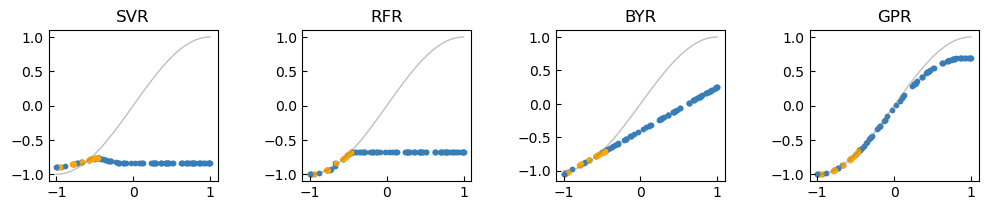

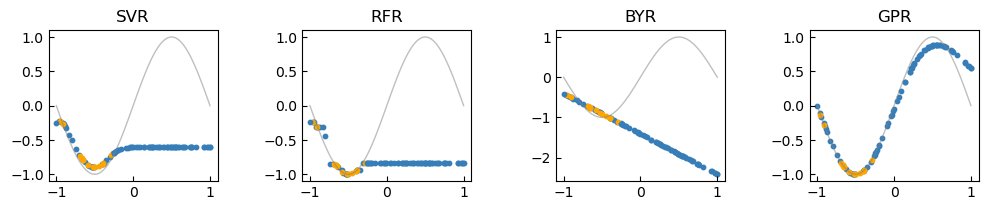

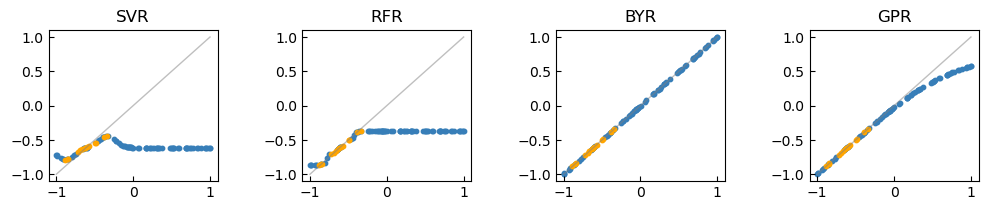

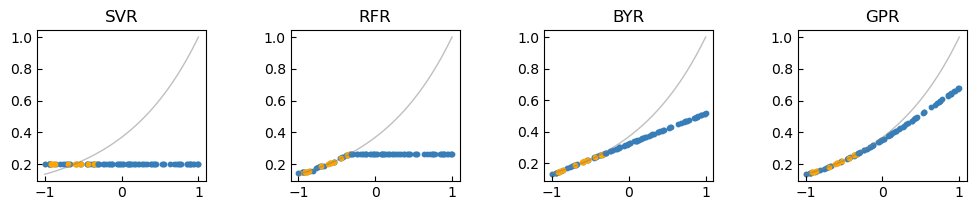

In [12]:
x_dim=1
n_qubit=2
depth=3
model_dict={}
#model_dict["QCL"]=StandardQCLRegressor(x_dim=x_dim,n_qubit=n_qubit,encoder=XYEncoder(n_qubit),observable=ZObservable(n_qubit=n_qubit,coeff=2),vqe_gates=CNOTRotationGates(n_qubit=n_qubit,depth=depth))
model_dict["SVR"]=SVR()
model_dict["RFR"]=RandomForestRegressor()
model_dict["BYR"]=BayesianRidge()
model_dict["GPR"]=GaussianProcessRegressor(kernel=WhiteKernel()+RBF())
#model_dict["DNN"]=DNNModel(hidden_dim=8,layers=1,activation="relu")


for n in [100]:
    for mode in ["sin1/2","sin","linear","exp"]:
    #for mode in ["sin1/2","sin","sin2","linear","exp"]:
        tr_X,tr_y,te_inner_X,te_inner_y,te_low_X,te_low_y,te_high_X,te_high_y,act_X,act_y=prepare_dataset(
            n_all_record=n,
            mode=mode,
            plot=False,
            extra_high_ratio=0.6,
            extra_low_ratio=0.01,
            inner_test_ratio=0.01)


        i=0

        fig = plt.figure(figsize=(12,2),dpi=100)
        for model_name,model in model_dict.items():
            model.fit(tr_X,tr_y)
            plt.subplots_adjust(wspace=0.5, hspace=0.6)
            ax = fig.add_subplot(1, len(list(model_dict.keys())), i+1)
            eval(ax,model,tr_X,tr_y,te_inner_X,te_inner_y,te_low_X,te_low_y,te_high_X,te_high_y,act_X,act_y,title=model_name)
            i+=1


#circuit_drawer(model.vqe_gates.circuit)